# Desafio 2: Regressão

## Análise do Problema

In [61]:
import pandas as pd
import numpy as np

In [62]:
df = pd.read_csv('/content/drive/MyDrive/curso_machine-learning-python/datasets/insurance.csv')

In [63]:
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


Com os dados acima, você pode prever os preços (charges) do convênio?

Podemos começar, conhecendo cada um dos dados disponíveis:



*   Age (idade): é a idade do beneficiário principal.
*   Sex (sexo): é o sexo do contratante, male (masculino) ou female (feminino).
* bmi (imc): o body mass index (índice de massa corporal) é calculado pelo peso dividido pela altura ao quadrado (peso / altura²). Idealmente, deve estar entre 18.5 e 24.9.
*   children (crianças): o número de crianças cobertas pelo plano de saúde (número de dependentes).
*   smoker (fumante): se o beneficiário principal ou contratante é fumante? Pouco específico.
*   region (região): área residencial do beneficiário nos Estados Unidos, pode ser: northeast (nordeste), southeast (sudeste), southwest (sudoeste) ou northwest (noroeste).
*   charges (custos): custos médicos cobrados pelo plano de saúde/convênio médico.

Charges é nossa variável dependente, enquanto as outras são as variáveis independentes.

In [64]:
df.dtypes

,0
age,int64
sex,object
bmi,float64
children,int64
smoker,object
region,object
charges,float64


Com relação aos tipos dessas variáveis temos:
*   age: numérica discreta
*   sex: categórica nominal
*   bmi: numérica contínua
*   children: numérica discreta
*   smoker: categórica nominal
*   region: categórica nominal
*   charges: numérica contínua

Dado que charges que a variável que queremos prever é numérica contínua, esse é um problema mais adequado de ser resolvido com um modelo de regressão.



## Exploração dos dados

Essa seção busca entender como os dados estão distribuídos.

In [65]:
print(f"Temos {df.shape[0]} registros com {df.shape[1]} colunas cada")

Temos 1338 registros com 7 colunas cada


In [66]:
import seaborn as sns

### Distribuições

#### Age

<Axes: xlabel='age', ylabel='Count'>

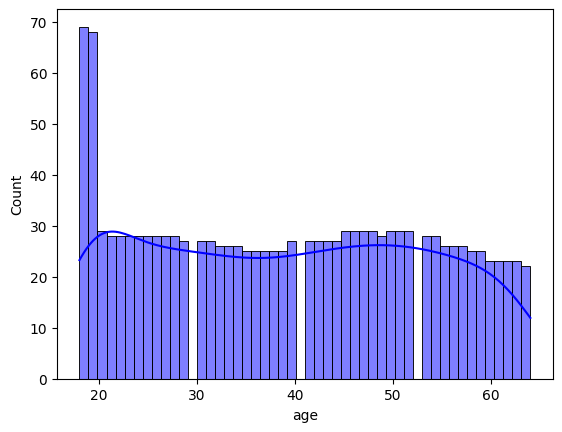

In [67]:
sns.histplot(df, x = 'age', bins = 50, color = 'blue', kde = True, stat = 'count')

Conclusão: Age não segue uma distribuição normal nesse dataset. A faixa de idade mais comum está entre 10-20 anos e a faixa de idade menos comum é 70+.

#### Sex

<Axes: xlabel='sex', ylabel='count'>

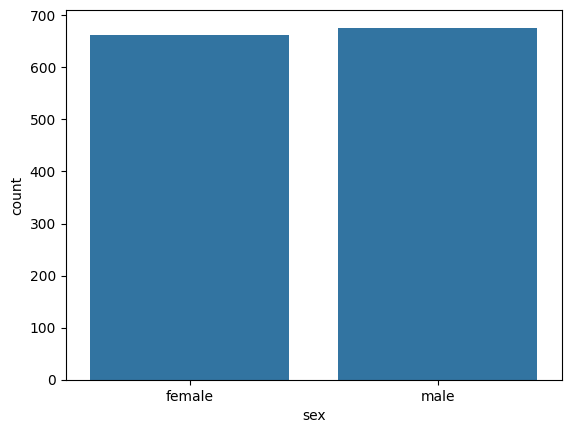

In [68]:
sns.countplot(x = 'sex', data = df)

Conclusão: Os sexos masculino e feminino aparecem de forma balanceada no dataset.

#### BMI

<Axes: xlabel='bmi', ylabel='Count'>

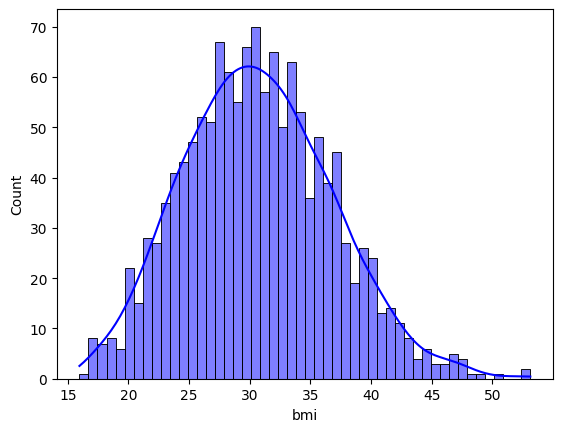

In [69]:
sns.histplot(df, x = 'bmi', bins = 50, color = 'blue', kde = True, stat = 'count')

Conclusão: A distribuição do BMI (IMC) se parece normal. Com média próxima de 30 e a maior parte das pessoas com BMI entre 25 e 35.

#### Children

In [70]:
import plotly.express as px

In [71]:
children_hist = px.histogram(df, x = "children", nbins = 12)
children_hist.show()

Conclusão: Children também não é uma distribuição normal. É mais comum as pessoas não terem filhos. Ter de 1 a 2 filhos é tão comum quanto não ter filhos. Ter 4+ filhos são cenários menos comuns.

#### Smoker

<Axes: xlabel='smoker', ylabel='count'>

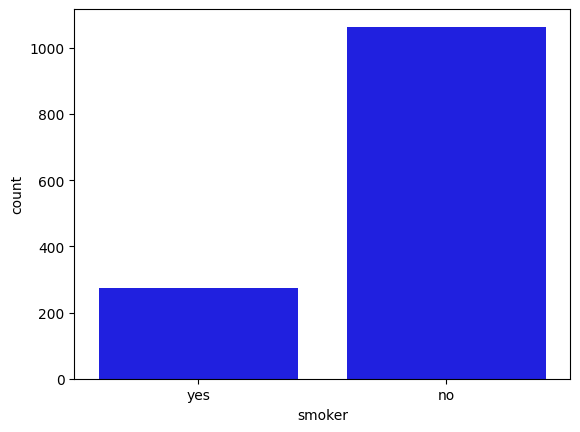

In [72]:
sns.countplot(data = df, x = 'smoker', stat = 'count', color = 'blue')

<Axes: xlabel='smoker', ylabel='percent'>

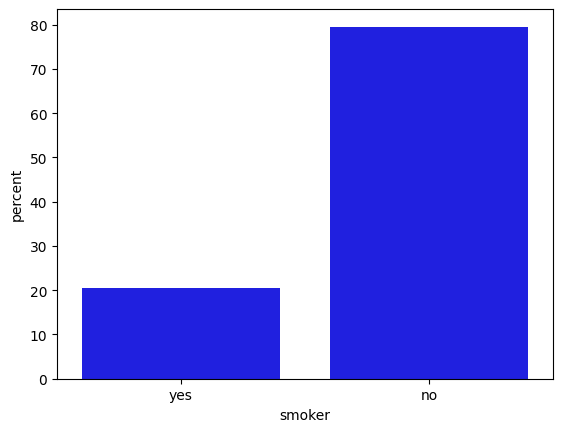

In [73]:
sns.countplot(data = df, x = 'smoker', stat = 'percent', color = 'blue')

Conclusão: A maior parte das pessoas que buscam convênio não fumam, cerca de 80%. Contra 20% de fumantes.

Quando exibimos o gráfico de barras com a variável sexo, não foi preciso mostrar percentuais porque havia praticamente um empate (50% / 50%). Com smoker, fica mais legível mostrar um gráfico de porcentagem.

#### Region

<Axes: xlabel='region', ylabel='count'>

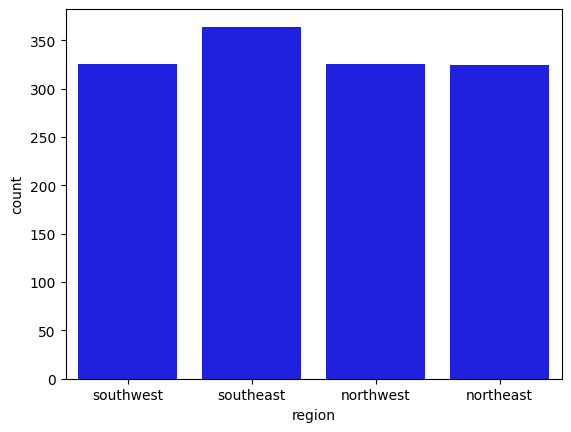

In [74]:
sns.countplot(data = df, x = 'region', stat = 'count', color = 'blue')

Conclusão: As pessoas que buscam convênio estão bem distribuídas por região. A região que mais aparece é a Sudeste.
Talvez seja a mais popula nos EUA, assim como é no Brasil.

#### charges (target)

<Axes: xlabel='charges', ylabel='Percent'>

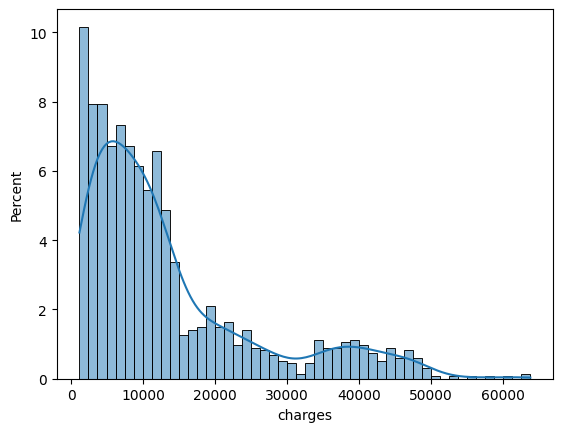

In [75]:
sns.histplot(data = df, x = 'charges', stat = 'percent', bins = 50, kde = True)

##### Gráfico Q-Q plot

In [76]:
import scipy.stats as stats
import matplotlib.pyplot as plt

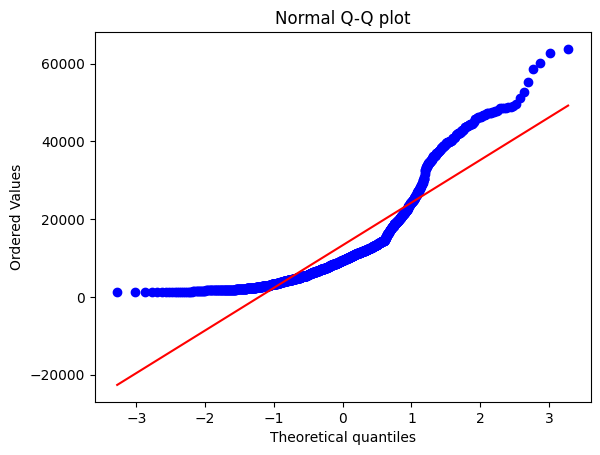

In [77]:
stats.probplot(df["charges"], dist="norm", plot = plt)
plt.title("Normal Q-Q plot")
plt.show()

Pelos testes anteriores, já podemos ver que charges não segue uma distribuição normal. Mesmo assim, vamos fazer um teste de Shapiro-Wilk, que tem o objetivo de identificar se um conjunto de dados segue uma distribuição normal.

O teste de Shapiro-Wilk é definido dessa forma:
- H_0 = Hipótese nula: amostra segue distr. normal - Quando p > 0.05
- H_a = Hipótese alternativa: amostra não segue distr. normal - Quando p <= 0.05


In [78]:
# stats.shapiro?
statistic, p = stats.shapiro(df["charges"])
print(f"p = {p}")
print(f"A distribuicao : {'É normal' if p > 0.05 else 'Não é normal'}")

p = 1.1505226334932036e-36
A distribuicao : Não é normal


Conclusão: como podemos ver, a distribuição não é normal para charges. Temos uma grande número de pessoas pagando até 15000. Valores maiores que isso é mais incomum.

### Análise de Correlação

A ideia dessa seção é avaliar se cada uma das variáveis independentes está correlacionada com a variável dependente (charges). Se sim, podemos usá-las nos nossos modelos.

Na parte gráfica, podemos usar o gráfico de espalhamento (scatter). Mas na parte teórica, precisaremos usar um teste de correlação diferente do teste de Pearson (para dados que seguem distribuição normal).

#### Gráfico de espalhamento e testes de correlação (variável por variável)

##### Age x Charges

In [79]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Charges')

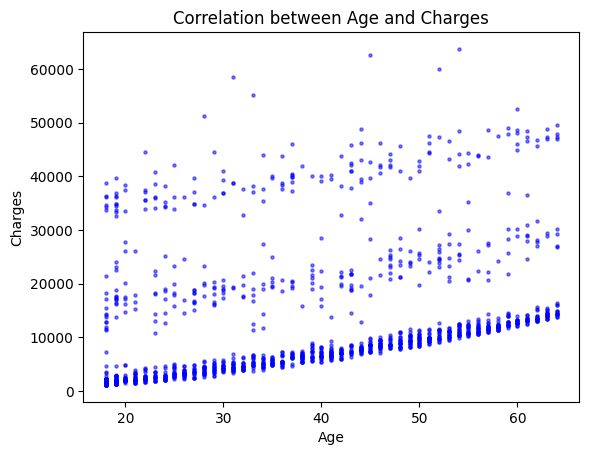

In [80]:
plt.scatter(df["age"], df["charges"], color = "blue", s = 5, alpha = 0.5)
plt.title("Correlation between Age and Charges")
plt.xlabel("Age")
plt.ylabel("Charges")


In [81]:
import scipy.stats as stats

In [82]:
#stats.spearmanr?

In [83]:
coef, p = stats.spearmanr(df["charges"], df["age"])
print(f"coef: {coef}, p: {p}")

coef: 0.534392133771846, p: 1.1306920278035412e-99


Eles não são os mais apropriados, mas como se sairiam os testes de Pearson e Kendall para essas duas colunas?

In [84]:
coef, p = stats.pearsonr(df["charges"], df["age"])
print(f"coef: {coef}, p: {p}")

coef: 0.2990081933306476, p: 4.886693331718529e-29


In [85]:
coef, p = stats.kendalltau(df["charges"], df["age"])
print(f"coef: {coef}, p: {p}")

coef: 0.47530235429087664, p: 2.5890786414449767e-146


In [86]:
df['age'].mean()

np.float64(39.20702541106129)

Conclusão: Para essa primeira variável, podemos ver que parece existir uma correlação entre as variáveis, mas que outros fatores também podem influenciar. Isso acaba ficando mais nítido quando usamos o teste de Spearman e ele aponta uma correlação positiva de aproximadamente 0.53, que é quase fraca, mas já atingindo um nível moderado (coef > 0.5). Por outro lado, o teste de Kendall aponta correlação positiva fraca com valor aproximado de 0.48. Podemos usar essa variável para treinar o modelo, mas é necessário verificar o treinamento também sem ela.

##### Sex X Charges

Se a variável charges seguisse uma distribuição normal, poderíamos usar o teste t de student.

Se a variável sex tivesse mais de duas categorias e charges seguisse uma distribuição normal, poderíamos usar análise de variância (ANOVA).

Como nenhum dos 2 é verdade, uma possibilidade é usar boxplots separados por categoria para visualizar os dados.

In [87]:
charges_of_male = df[df['sex'] == 'male']['charges']

In [88]:
charges_of_female = df[df['sex'] == 'female']['charges']

{'whiskers': [<matplotlib.lines.Line2D at 0x7bd7e0961f10>,
 'caps': [<matplotlib.lines.Line2D at 0x7bd7e09632d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7bd7e0961590>],
 'medians': [<matplotlib.lines.Line2D at 0x7bd7e0974510>],
 'fliers': [<matplotlib.lines.Line2D at 0x7bd7e0974dd0>],
 'means': []}

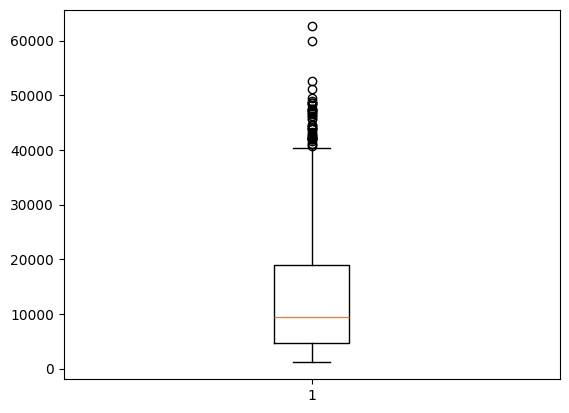

In [89]:
plt.boxplot(charges_of_male)

{'whiskers': [<matplotlib.lines.Line2D at 0x7bd7e09c1250>,
 'caps': [<matplotlib.lines.Line2D at 0x7bd7e09c2610>,
 'boxes': [<matplotlib.lines.Line2D at 0x7bd7e09c0990>],
 'medians': [<matplotlib.lines.Line2D at 0x7bd7e0967dd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7bd7e09c1ad0>],
 'means': []}

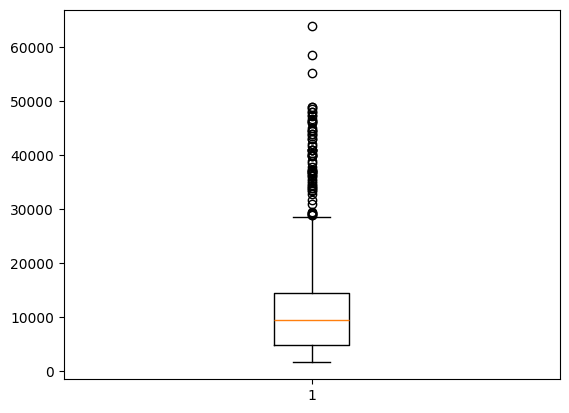

In [90]:
plt.boxplot(charges_of_female)

Conclusão:

Para homens - A mediana está em torno de 10.000. O 3º quartil está em torno de 20.000. Os valores mais altos estão em cerca de 40.000 e valores mais altos que isso são considerados outliers. Os outliers estão entre 40.000 e 50.000 em sua maioria.

Para mulheres - A mediana está em torno de 10.000. O 3º quartil aparece mais abaixo, em torno de 14.000. Os valores mais alto estão em cerca de 30.000 e valores maiores que isso são considerados outliers. Os outliers estão entre 30.000 e 50.000 em sua maioria.


In [91]:
import matplotlib.pyplot as plt


Text(0.5, 1.0, 'Charges by Citizen (in U$ dollars)')

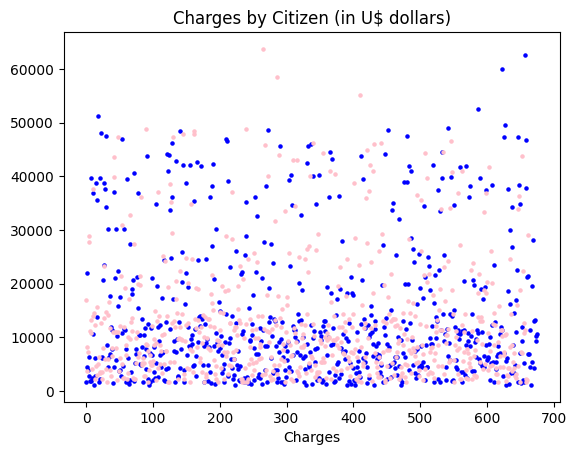

In [92]:
plt.scatter(range(0, len(charges_of_male)), charges_of_male, color = 'blue', s = 5)
plt.scatter(range(0, len(charges_of_female)), charges_of_female, color = 'pink', s = 5)
plt.xlabel("Citizen")
plt.xlabel("Charges")
plt.title("Charges by Citizen (in U$ dollars)")

In [93]:
np.mean(charges_of_male)

np.float64(13956.751177721893)

In [94]:
np.mean(charges_of_female)

np.float64(12569.578843835347)

Apesar das medianas serem bem próximas, homens pagam em média U$1400 a mais que mulheres.

##### BMI x Charges

Text(0.5, 1.0, 'Correlation between BMI and charges')

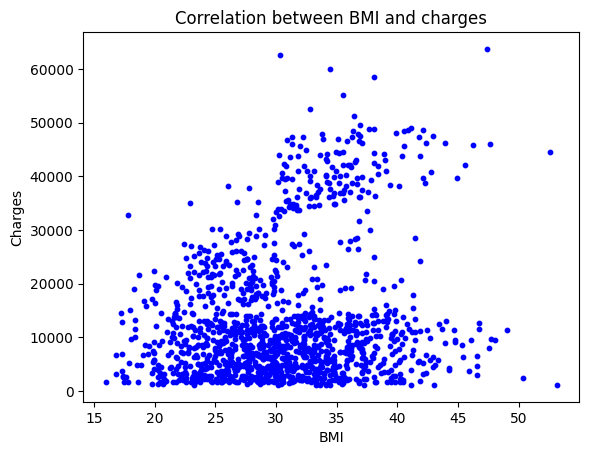

In [95]:
plt.scatter(x = df["bmi"], y = df["charges"], color = 'blue', s = 10)
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.title("Correlation between BMI and charges")

Não temos visualmente uma correlação tão forte, mas parece claro que se o IMC é maior que 30 há mais chances de os charges (custos) serem mais altos. E como vimos anteriormente que charges não se parece com uma distribuição normal, vamos usar o teste de Spearman.

In [96]:
import scipy.stats as stats

In [97]:
correlation_coefficient, p = stats.spearmanr(df["charges"], df["bmi"])
print(f"Coeficiente de correlação: {correlation_coefficient}, p: {p}")

Coeficiente de correlação: 0.11939590358331147, p: 1.1926059544526826e-05


Deu um valor muito baixo, talvez vale testar com os outros, mas parece que essa variável BMI não ajudaria na construção do modelo.

In [98]:
correlation_coefficient, p = stats.pearsonr(df["charges"], df["bmi"])
print(f"Coeficiente de correlação: {correlation_coefficient}, p: {p}")

Coeficiente de correlação: 0.1983409688336289, p: 2.4590855351167345e-13


In [99]:
correlation_coefficient, p = stats.kendalltau(df["charges"], df["bmi"])
print(f"Coeficiente de correlação: {correlation_coefficient}, p: {p}")

Coeficiente de correlação: 0.08252397079981416, p: 6.256900640955888e-06


Conclusão: Como podemos ver por todos esses coeficientes, BMI está longe de poder contribuir para a construção de um modelo de previsão de custos do plano médico.

##### Children x Charges

In [100]:
import random

In [101]:
random.random()

0.05292025227344932

Text(0.5, 1.0, 'Correlation between # of children and charges with health')

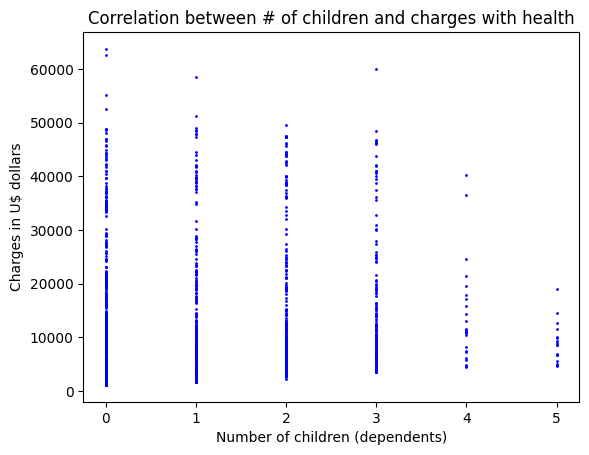

In [102]:
plt.scatter(x = df.children, y = df.charges, color = 'blue', s = 1)
plt.xlabel("Number of children (dependents)")
plt.ylabel("Charges in U$ dollars")
plt.title("Correlation between # of children and charges with health")

Muito confuso esse gráfico. Parece não ter correção. Talvez o calcular a média de cada sub-grupo seja mais interessante. Mas além disso, vou calcular o índice de spearmann.

In [103]:
import scipy.stats as stats

In [104]:
corr_coef, p_value = stats.spearmanr(df.charges, df.children)
print(f"Correlation coefficient: {corr_coef}, p-value: {p_value}")

Correlation coefficient: 0.13333894319168219, p-value: 9.846806132997262e-07


Índice de correlação bem baixo como esperado.

##### Smoker x Charges

In [105]:
smoker_charges = df[df['smoker'] == 'yes']['charges']

In [106]:
non_smoker_charges = df[df['smoker'] == 'no']['charges']

{'whiskers': [<matplotlib.lines.Line2D at 0x7bd7e078b490>,
 'caps': [<matplotlib.lines.Line2D at 0x7bd7e07947d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7bd7e078acd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7bd7e0795bd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7bd7e0796710>],
 'means': []}

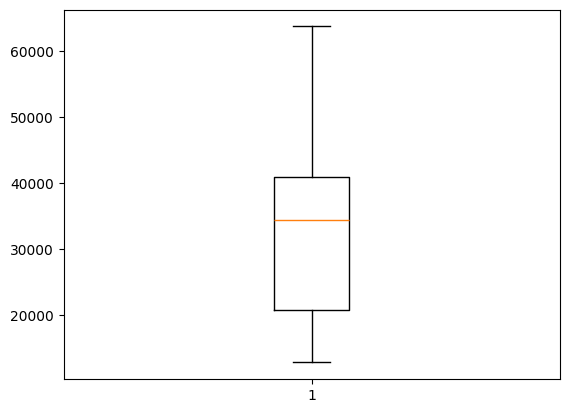

In [107]:
plt.boxplot(smoker_charges)

{'whiskers': [<matplotlib.lines.Line2D at 0x7bd7e05f4c10>,
 'caps': [<matplotlib.lines.Line2D at 0x7bd7e05f60d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7bd7e05f4110>],
 'medians': [<matplotlib.lines.Line2D at 0x7bd7e05f76d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7bd7e0604210>],
 'means': []}

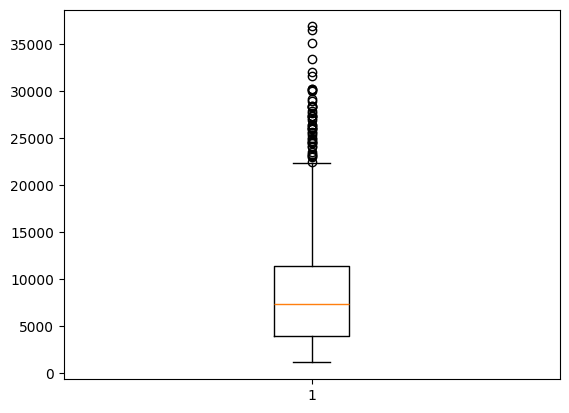

In [108]:
plt.boxplot(non_smoker_charges)

In [109]:
smoker_charges.mean()

np.float64(32050.23183153284)

In [110]:
non_smoker_charges.mean()

np.float64(8434.268297856204)

Conclusão: A variável Smoker é bem relevante para os custos. Pessoas fumantes chegam a pagar em média 32k para o plano de saúde. Enquanto isso, pessoas não fumantes, chegam a pagar 8.4k para os planos de saúde.

##### Region x Charges

In [111]:
southeast_charges = df[df['region'] == 'southeast']['charges']
southwest_charges = df[df['region'] == 'southwest']['charges']
northeast_charges = df[df['region'] == 'northeast']['charges']
northwest_charges = df[df['region'] == 'northwest']['charges']

{'whiskers': [<matplotlib.lines.Line2D at 0x7bd7e065d550>,
 'caps': [<matplotlib.lines.Line2D at 0x7bd7e065ebd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7bd7e065cb10>],
 'medians': [<matplotlib.lines.Line2D at 0x7bd7e06644d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7bd7e0614090>],
 'means': []}

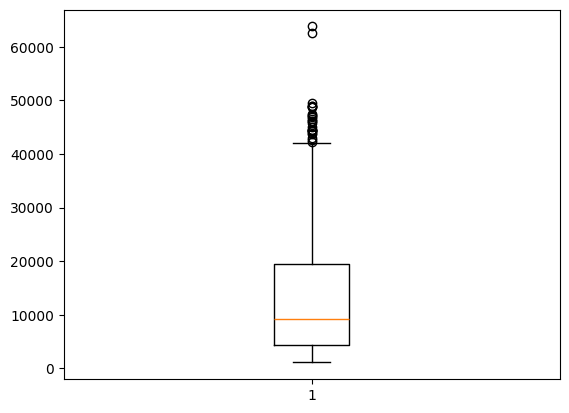

In [112]:
plt.boxplot(southeast_charges)

{'whiskers': [<matplotlib.lines.Line2D at 0x7bd7e068d510>,
 'caps': [<matplotlib.lines.Line2D at 0x7bd7e068eb50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7bd7e068c910>],
 'medians': [<matplotlib.lines.Line2D at 0x7bd7e0698090>],
 'fliers': [<matplotlib.lines.Line2D at 0x7bd7e0698b50>],
 'means': []}

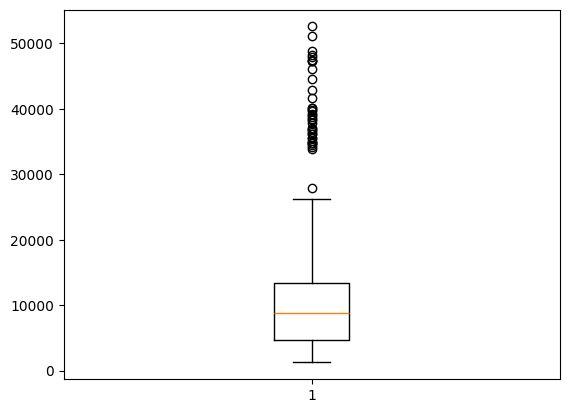

In [113]:
plt.boxplot(southwest_charges)

{'whiskers': [<matplotlib.lines.Line2D at 0x7bd7e06e8d50>,
 'caps': [<matplotlib.lines.Line2D at 0x7bd7e06ea410>,
 'boxes': [<matplotlib.lines.Line2D at 0x7bd7e06e8150>],
 'medians': [<matplotlib.lines.Line2D at 0x7bd7e06eba50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7bd7e04f84d0>],
 'means': []}

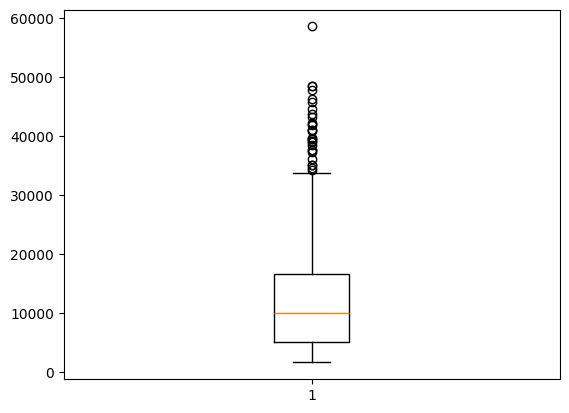

In [114]:
plt.boxplot(northeast_charges)

{'whiskers': [<matplotlib.lines.Line2D at 0x7bd7e05460d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7bd7e0539790>,
 'boxes': [<matplotlib.lines.Line2D at 0x7bd7e0545610>],
 'medians': [<matplotlib.lines.Line2D at 0x7bd7e0550d10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7bd7e0551810>],
 'means': []}

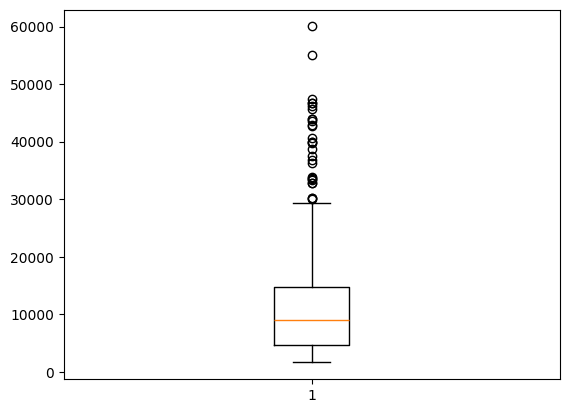

In [115]:
plt.boxplot(northwest_charges)

In [116]:
southeast_charges.mean()

np.float64(14735.411437609888)

In [117]:
southwest_charges.mean()

np.float64(12346.937377292308)

In [118]:
northeast_charges.mean()

np.float64(13406.384516385804)

In [119]:
northwest_charges.mean()

np.float64(12417.57537396923)

Conclusão: Region parece ser uma variável relevante para ser usada. Principalmente quando se trata do 3º quartil e valores máximos, existem diferenças entre as regiões. A mediana é muito parecida para todos as regiões. A partir dos valores médios, também percebemos que o leste dos EUA paga em média mais caro do que o oeste. Talvez possam ser criadas features para indicar se o contratante está no leste ou no oeste.

#### Estatística Descritiva

In [120]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Conclusão da análise do problema

Algumas variáveis parecem ser mais relevantes para a criação do modelo. No meu palpite inicial, eu diria que vou usar as seguintes variáveis: Age, Sex, Smoker e Region. Também posso testar o modelo incluindo BMI e Children para ver como o mesmo se comporta.

Caso BMI e Children não se saiam bem, posso tentar derivar o peso de BMI usando alturas médias de homens/mulheres estado-unidenses.

Da variável Region, também é possível derivar uma segunda variável de regiões, binária, e formada por Leste e Oeste.